https://zhuanlan.zhihu.com/p/112362700

In [2]:
import re
import random
import jieba
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import gensim
from gensim.models import Word2Vec
from sklearn.preprocessing import scale
import multiprocessing

In [36]:
corpus = [
    '花呗更改绑定银行卡',
    '我什么时候开通了花呗',
    'A man is eating food.',
    'A man is eating a piece of bread.',
    'The girl is carrying a baby.',
    'A man is riding a horse.',
    'A woman is playing violin.',
    'Two men pushed carts through the woods.',
    'A man is riding a white horse on an enclosed ground.'
]

In [26]:
jieba.add_word("花呗")

In [27]:
def preprocess_text(content_lines, sentences):
    for line in content_lines:
        try:
            segs=jieba.lcut(line)
            segs = [v for v in segs if not str(v).isdigit()]#去数字
            segs = list(filter(lambda x:x.strip(), segs))   #去左右空格
            segs = list(filter(lambda x:len(x)>1, segs)) #长度为1的字符
            # segs = list(filter(lambda x:x not in stopwords, segs)) #去掉停用词
            sentences.append(" ".join(segs))
        except Exception:
            print(line)
            continue

In [37]:
sentences = []
# 处理语料，语料的处理结果存放在sentences
preprocess_text(corpus, sentences)

In [38]:
sentences

['花呗 更改 绑定 银行卡',
 '什么 时候 开通 花呗',
 'man is eating food',
 'man is eating piece of bread',
 'The girl is carrying baby',
 'man is riding horse',
 'woman is playing violin',
 'Two men pushed carts through the woods',
 'man is riding white horse on an enclosed ground']

In [39]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5)
#统计每个词语的tf-idf权值
transformer = TfidfTransformer()
# 第一个fit_transform是计算tf-idf 第二个fit_transform是将文本转为词频矩阵
tfidf = transformer.fit_transform(vectorizer.fit_transform(sentences))
# 获取词袋模型中的所有词语
word = vectorizer.get_feature_names_out()
# 将tf-idf矩阵抽取出来，元素w[i][j]表示j词在i类文本中的tf-idf权重
weight = tfidf.toarray()
#查看特征大小
print ('Features length: ' + str(len(word)))

Features length: 33


In [47]:
weight.shape

(9, 33)

In [48]:
from sklearn.decomposition import PCA

class JieKmeans:
    def __init__(self, numClass=4, n_components=10, func_type='PCA'):
        #这里也可以选择随机初始化init="random"

        self.PCA = PCA(n_components=n_components)
        if func_type == 'PCA':
            self.func_plot = PCA(n_components=2)
        elif func_type == 'TSNE':
            from sklearn.manifold import TSNE
            self.func_plot = TSNE(2)

        self.numClass = numClass

    def plot_cluster(self, result, newData):

        plt.figure(2)
        Lab = [[] for i in range(self.numClass)]
        index = 0
        for labi in result:
            Lab[labi].append(index)
            index += 1
        color = ['oy', 'ob', 'og', 'cs', 'ms', 'bs', 'ks', 'ys', 'yv', 'mv', 'bv', 'kv', 'gv', 'y^', 'm^', 'b^', 'k^',
                    'g^'] * 3

        for i in range(self.numClass):
            x1 = []
            y1 = []
            for ind1 in newData[Lab[i]]:
                # print ind1
                try:
                    y1.append(ind1[1])
                    x1.append(ind1[0])
                except:
                    pass
            plt.plot(x1, y1, color[i])

        #绘制初始中心点
        x1 = []
        y1 = []
        for ind1 in self.model.cluster_centers_:
            try:
                y1.append(ind1[1])
                x1.append(ind1[0])
            except:
                pass
        plt.plot(x1, y1, "rv") #绘制中心
        plt.show()


    def train(self, data):
        tmp = self.PCA.fit_transform(data)
        self.model = KMeans(
            n_clusters=self.numClass,
            max_iter=10000, init="k-means++", tol=1e-6)
        s = self.model.fit(tmp)
        print("聚类算法训练完成\n", s)



    def predict(self, data):
        t_data = self.PCA.fit_transform(data)
        result = list(self.model.predict(t_data))
        return result


    def plot(self, weight):
        t_data = self.PCA.fit_transform(weight)
        result = list(self.model.predict(t_data))
        plot_pos = self.func_plot.fit_transform(weight)
        self.plot_cluster(result, plot_pos)

In [49]:
net = JieKmeans(
    numClass=3,
    n_components=5,
    func_type='PCA'
    )

net.train(weight)
# net.plot(weight)

聚类算法训练完成
 KMeans(max_iter=10000, n_clusters=3, tol=1e-06)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


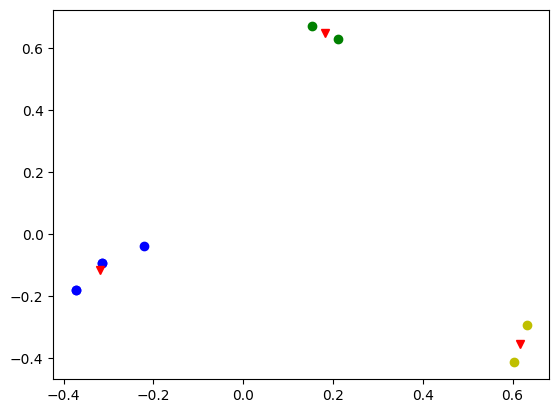

In [50]:
net.plot(weight)

In [51]:
p = net.predict(weight)

class_data = {
    i:[]
    for i in range(3)
}

for text,cls in zip(corpus, p):
    class_data[cls.item()].append(text)

class_data

{0: ['A man is riding a horse.',
  'A man is riding a white horse on an enclosed ground.'],
 1: ['花呗更改绑定银行卡',
  '我什么时候开通了花呗',
  'The girl is carrying a baby.',
  'A woman is playing violin.',
  'Two men pushed carts through the woods.'],
 2: ['A man is eating food.', 'A man is eating a piece of bread.']}